In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
import seaborn as sns

Wi = pd.read_csv("ninja_wind_49.0069_8.4034_corrected.csv", sep = ",",header=3)

W= Wi.iloc[ :, 2]


In [6]:

#AUFGABE A--------------------------------------------------------------------------------------------------------------

#Index vom Start des Intervalls herausfinden
for index, row in Wi.iterrows():
    if row["local_time"] == "2019-12-02 00:00":
        start_index = index
        print(f"Start index is: {start_index}")

#Index vom Ende des Intervalls herausfinden
for index, row in Wi.iterrows():
    if row["local_time"] == "2019-12-08 23:00":
        end_index = index
        print(f"End index is: {end_index}")

#Date und electricity in Array speichern, um darauf per while-Schleife zuzugreifen
W_electricity = np.array(Wi.electricity)

#Loope durch Intervall
t = start_index
actual = []
naive_prediction = []
easy_error = 0 #Einfacher Fehler: Ist-Wert minus prognostizierter-Wert
absolute_error = 0 #Betragsfehler: abs(Ist-Wert minus prognostizierter-Wert)
square_error = 0

while t >= start_index and t <= end_index:
    seven_days = [W_electricity[t-(1*24)], W_electricity[t-(2*24)], W_electricity[t-(3*24)], W_electricity[t-(4*24)], W_electricity[t-(5*24)], W_electricity[t-(6*24)], W_electricity[t-(7*24)]]
    average = round((sum(seven_days) / len(seven_days)),3)
    actual.append(W_electricity[t]) #Wird für Aufgabe C gebraucht
    naive_prediction.append(average) #Wird für Aufgabe C gebraucht
    easy_error = W_electricity[t] - average + easy_error
    absolute_error = abs(W_electricity[t] - average) + absolute_error
    square_error = (W_electricity[t] - average)** 2 + square_error
    t = t + 1

mean_square_error = square_error/(end_index-start_index+1)
root_mean_square_error = (mean_square_error)**0.5

print(f"Easy Error is: {easy_error}")
print(f"Absolute Error is: {absolute_error}")
print(f"Mean Square Error is: {mean_square_error}")
print(f"Root Mean Square Error is: {root_mean_square_error}")



#AUFGABE B--------------------------------------------------------------------------------------------------------------








Start index is: 8039
End index is: 8206
Easy Error is: 78.00300000000009
Absolute Error is: 383.293
Mean Square Error is: 7.5681117678571415
Root Mean Square Error is: 2.7510201322158916


In [7]:


def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

#Split data set into testing dataset and train dataset
train_size = 8016
look_back = 168
train, test =W.to_frame().values[0:train_size,:],W.to_frame().values[train_size-look_back:len(W.values),:]
# setup look_back window

#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)



def model_dnn(look_back):
    model=Sequential()
    model.add(Dense(units=32, input_dim=look_back, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    return model

model=model_dnn(look_back)

history=model.fit(trainX,trainY, epochs=100, batch_size=30, verbose=1, validation_data=(testX,testY),callbacks=[EarlyStopping(monitor="val_loss", patience=10)],shuffle=False)



Epoch 1/100
262/262 [==============================] - 3s 5ms/step - loss: 2.5395 - mse: 2.5395 - mae: 1.0828 - val_loss: 1.1530 - val_mse: 1.1530 - val_mae: 0.8360
Epoch 2/100
262/262 [==============================] - 1s 4ms/step - loss: 0.8647 - mse: 0.8647 - mae: 0.6682 - val_loss: 0.6756 - val_mse: 0.6756 - val_mae: 0.6340
Epoch 3/100
262/262 [==============================] - 1s 4ms/step - loss: 0.6486 - mse: 0.6486 - mae: 0.5949 - val_loss: 0.9274 - val_mse: 0.9274 - val_mae: 0.7281
Epoch 4/100
262/262 [==============================] - 1s 5ms/step - loss: 0.9735 - mse: 0.9735 - mae: 0.7255 - val_loss: 1.3518 - val_mse: 1.3518 - val_mae: 0.8494
Epoch 5/100
262/262 [==============================] - 1s 4ms/step - loss: 0.6523 - mse: 0.6523 - mae: 0.5794 - val_loss: 0.9067 - val_mse: 0.9067 - val_mae: 0.6828
Epoch 6/100
262/262 [==============================] - 1s 5ms/step - loss: 0.4604 - mse: 0.4604 - mae: 0.4929 - val_loss: 0.8587 - val_mse: 0.8587 - val_mae: 0.6802
Epoch 7/10

In [8]:
 def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();



Train Root Mean Squared Error(RMSE): 0.43; Train Mean Absolute Error(MAE) : 0.30 
Test Root Mean Squared Error(RMSE): 0.53; Test Mean Absolute Error(MAE) : 0.39 


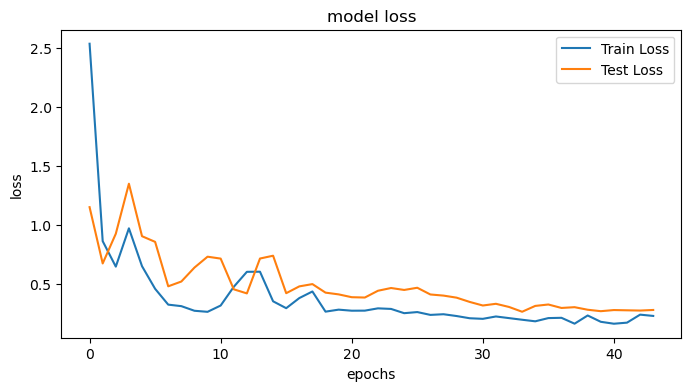

In [9]:
train_score = model.evaluate(trainX, trainY, verbose=0)
print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(train_score[1]), train_score[2]))
test_score = model.evaluate(testX, testY, verbose=0)
print('Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(test_score[1]), test_score[2]))
model_loss(history)

In [46]:
  def prediction_plot(testY, test_predict):
      len_prediction=[x for x in range(len(testY))]
      plt.figure(figsize=(8,4))
      plt.plot(len_prediction, testY, marker='.', label="actual")
      plt.plot(len_prediction, test_predict, 'r', label="prediction")
      plt.tight_layout()
      sns.despine(top=True)
      plt.subplots_adjust(left=0.07)
      plt.ylabel('Ads Daily Spend', size=15)
      plt.xlabel('Time step', size=15)
      plt.legend(fontsize=15)
      plt.show();
    
test_predict = model.predict(testX)


24/24 [==============================] - 0s 3ms/step


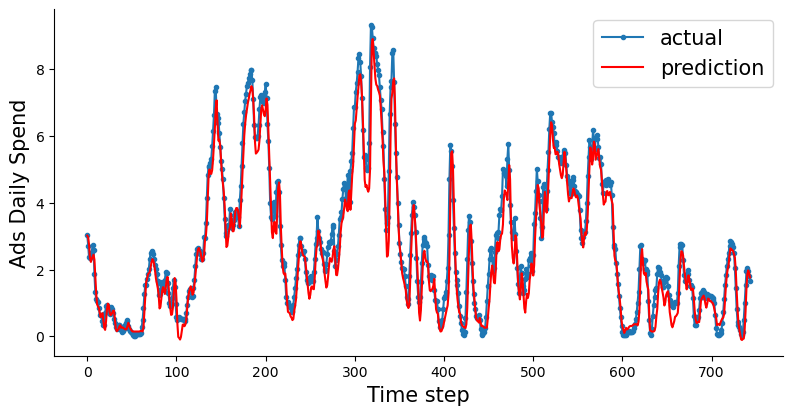

In [11]:
prediction_plot(testY, test_predict)


[0.893, 0.719, 0.679, 0.794, 0.875, 0.811, 0.714, 0.513, 0.399, 0.279, 0.234, 0.251, 0.328, 0.351, 0.312, 0.196, 0.127, 0.168, 0.218, 0.331, 0.402, 0.45, 0.493, 0.304, 0.219, 0.156, 0.132, 0.096, 0.04, 0.022, 0.022, 0.046, 0.073, 0.084, 0.083, 0.075, 0.059, 0.093, 0.277, 0.477, 0.841, 1.26, 1.527, 1.532, 1.705, 1.855, 2.013, 2.307, 2.508, 2.553, 2.537, 2.465, 2.315, 2.137, 2.008, 1.868, 1.666, 1.239, 1.262, 1.379, 1.563, 1.636, 1.476, 1.393, 1.695, 1.941, 1.897, 1.608, 1.292, 1.014, 0.924, 0.974, 1.14, 1.454, 1.702, 1.49, 0.967, 0.579, 0.495, 0.544, 0.578, 0.557, 0.527, 0.53, 0.508, 0.478, 0.474, 0.516, 0.71, 0.954, 1.178, 1.355, 1.433, 1.33, 1.188, 1.218, 1.44, 1.679, 2.099, 2.468, 2.614, 2.633, 2.565, 2.557, 2.444, 2.307, 2.307, 2.487, 2.976, 2.941, 3.406, 4.127, 4.835, 5.07, 5.103, 5.185, 5.322, 5.687, 6.153, 6.621, 7.334, 7.462, 6.641, 6.396, 6.523, 6.083, 5.677, 5.253, 5.007, 4.702, 4.144, 3.524, 3.0, 3.1, 3.277, 3.342, 3.282, 3.825, 3.481, 3.242, 3.342, 3.471, 3.628, 3.736, 3.723

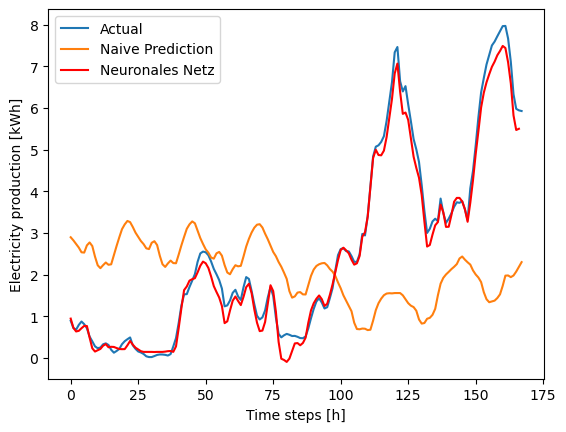

In [51]:
#AUFGABE C--------------------------------------------------------------------------------------------------------------
print(actual)
print(naive_prediction)


predict = np.concatenate(test_predict)[24:191]

#Werte einlesen
y1 = actual
y2 = naive_prediction
y3 = predict

#Beschriftung x- und y-Achse
plt.xlabel("Time steps [h]")
plt.ylabel("Electricity production [kWh]")



#Ausgabe der Daten und Anzeige der Legende
plt.plot(y1, label = "Actual")
plt.plot(y2, label = "Naive Prediction")
plt.plot(y3, 'r', label="Neuronales Netz")
plt.legend(loc="upper left")
plt.show()